# ECS7024 Statistics for Artificial Intelligence and Data Science

This notebook is a resource on coding related to the topic of **logistic regression**.

## Aims and Outline

The purpose of the note book is provide examples of **logistic regression**, which is regression where the **target variable is binary** (the 'target' is also known as the 'dependent' or 'outcome' variable). The techniques are illustrated using the 'Heart' dataset, where the disease status is a binary variable. 

**Contents**

1. Section 1: Fitting the Regression: Continuous Predictors
    1. Fitting the model
    2. Classification using the Model
2. Section 2: Accuracy, Confusion Matrix and ROC
    1. Confusion Matrix and the Performance Measures
    2. ROC and AUC


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_roc_curve
import seaborn as sns

%matplotlib inline

The dataset is on [Kaggle (in several places)](https://www.kaggle.com/ronitf/heart-disease-uci), referring to an original entry in th [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease). Our version using strings rather than numbers to encode categorical values.

The variables in the data set are shown below.

| Variable | Description and Values | Type |
|:---------:|:-----------|:-------|
| Age | The person's age in years | Continuous |
| Sex |Male or female: values 'M' or 'F'| Categorical |
| ChestPain | Type of chest pain. Values: 'Typical','Atypical','Non_anginal','Asymptomatic' | Categorical |
| RestBP | The person's resting blood pressure (mm Hg on admission to the hospital) | Continuous |
| Chol   | The person's cholesterol measurement in mg/dl | Continuous |
| Bsugar | Is the person's fasting blood sugar > 120 mg/dl. Values: True or False | Binary |
| RestECG |Resting electrocardiogram. Values 'Normal','ST-T wave','Hypertrophy' | Categorical |
| MaxRate | The person's maximum heart rate achieved | Continuous |
| Angina | Exercise induced angina. Values: True or False) |Binary |
| ECG_ST_d | ST depression induced by exercise relative to rest | Continuous |
| ECG_ST_slope | The slope of the peak exercise ST segment. Values: 'Upsloping', 'Flat', 'Downsloping' | Categorical |
| Vessels | The number of major vessels (0-3) coloured by fluoroscopy | Discrete |
| Thallium | Thallium update test (0 = normal; 1 = fixed defect; 2 = reversible defect) | Categorical |
| Disease  | Heart disease. Values: True or False | Binary |


In [2]:
# sex
sex_t = pd.CategoricalDtype(categories=['M','F'], ordered=False)

# Chest pain
pain_t = pd.CategoricalDtype(categories=['Typical','Atypical','Non_anginal','Asymptomatic'], ordered=False)

# RestECG
ECG_t = pd.CategoricalDtype(categories=['Normal','ST-T wave','Hypertrophy'], ordered=False)

# ECG_ST_slope
ECG_ST_t = pd.CategoricalDtype(categories=['Upsloping', 'Flat', 'Downsloping'], ordered=False)
    
# Thal thalassemia 
Thal_t = pd.CategoricalDtype(categories=['Normal','Fixed','Reversible'], ordered=False)

# Type dictionary
types_dict = {'Sex':sex_t, 'ChestPain':pain_t, 'RestECG': ECG_t, 'ECG_ST_slope': ECG_ST_t, 'Thallium':Thal_t}

hearts = pd.read_csv('heart_cleveland_recoded.csv', dtype = types_dict)
hearts


,Age,Sex,ChestPain,RestBP,Chol,Bsugar,RestECG,MaxRate,Angina,ECG_ST_d,ECG_ST_slope,Vessels,Thallium,Disease
0,69,M,Typical,160,234,True,Hypertrophy,131,False,0.1,Flat,1,Normal,False
1,69,F,Typical,140,239,False,Normal,151,False,1.8,Upsloping,2,Normal,False
2,66,F,Typical,150,226,False,Normal,114,False,2.6,Downsloping,0,Normal,False
3,65,M,Typical,138,282,True,Hypertrophy,174,False,1.4,Flat,1,Normal,True
4,64,M,Typical,110,211,False,Hypertrophy,144,True,1.8,Flat,0,Normal,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,M,Asymptomatic,152,223,False,Normal,181,False,0.0,Upsloping,0,Reversible,True
293,39,M,Asymptomatic,118,219,False,Normal,140,False,1.2,Flat,0,Reversible,True
294,35,M,Asymptomatic,120,198,False,Normal,130,True,1.6,Flat,0,Reversible,True
295,35,F,Asymptomatic,138,183,False,Normal,182,False,1.4,Upsloping,0,Normal,False


## Section 1: Fitting the Regression: Continuous Predictors

We get a dataframe containing the continuous predictors. 

### Section 1.1: Fitting the Model

In [3]:
hearts_cont = hearts.loc[:,['Age', 'RestBP', 'Chol', 'MaxRate', 'ECG_ST_d', 'Vessels']]
hearts_cont

,Age,RestBP,Chol,MaxRate,ECG_ST_d,Vessels
0,69,160,234,131,0.1,1
1,69,140,239,151,1.8,2
2,66,150,226,114,2.6,0
3,65,138,282,174,1.4,1
4,64,110,211,144,1.8,0
...,...,...,...,...,...,...
292,40,152,223,181,0.0,0
293,39,118,219,140,1.2,0
294,35,120,198,130,1.6,0
295,35,138,183,182,1.4,0


Using the `LogisticRegression` implementation from `sklearn` we create a model and fit it to the data.

In [4]:
logit_reg = LogisticRegression(penalty='none')
logit_reg.fit(hearts_cont, hearts.Disease)
logit_reg.classes_

array([False,  True])

We can print out the coefficients. These are not easy to interpret. We know that an older person is more likely to have heart disease but this coefficient is negative. If we rerun the regression for a single predictor the sign changes (see Appendix). This is likely to be caused by correlation between the predictors.

In [22]:
names = hearts_cont.columns.values
beta = logit_reg.coef_[0]  
for i in range(0,len(names)):
    print('Predictor %s has beta = %4.3f' % (names[i], beta[i]))
print('Intercept = %4.3f' % logit_reg.intercept_[0])
print(logit_reg.coef_)

Predictor Age has beta = -0.036
Predictor RestBP has beta = 0.018
Predictor Chol has beta = 0.003
Predictor MaxRate has beta = -0.037
Predictor ECG_ST_d has beta = 0.624
Predictor Vessels has beta = 1.213
Intercept = 2.868
[[-0.03570853  0.01845559  0.00289863 -0.03729367  0.62428543  1.21279273]]


It is more informative to look at the **distribution of the probability** for the two cases. We show two visualisations of this, which clearly show that there are some mis-predictions.

We start by creating a data frame that contains the actual and predicted results.

In [6]:
true_proba = logit_reg.predict_proba(hearts_cont)[:,1] 
                # the prediction gives a probability for each class, in order of classes_
results = pd.DataFrame(data = {'Disease':hearts.Disease, 'Predicted_disease':true_proba})
results

,Disease,Predicted_disease
0,False,0.604641
1,False,0.831798
2,False,0.786866
3,True,0.379594
4,False,0.264562
...,...,...
292,True,0.134814
293,True,0.454070
294,True,0.635824
295,False,0.228267


Both the boxplot and the density show that the predicted probability is higher when there is heart disease but that there is some overlap. 

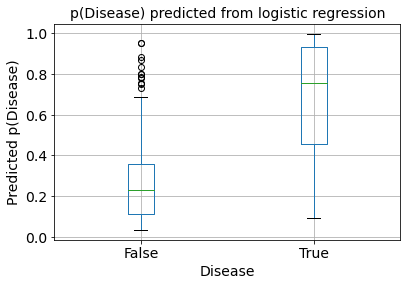

In [7]:
ax = results.boxplot(column='Predicted_disease', by='Disease', fontsize=14)
_ = plt.suptitle('')
ax.set_xlabel('Disease', fontsize=14)
ax.set_ylabel('Predicted p(Disease)', fontsize=14)
_ = ax.set_title('p(Disease) predicted from logistic regression', fontsize=14)

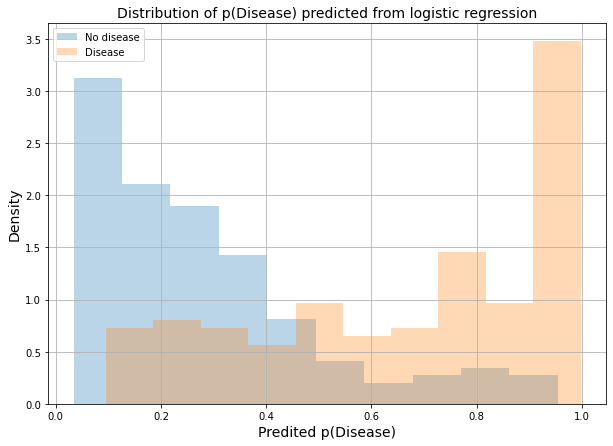

In [8]:
g = results.groupby('Disease')
fig, ax1 = plt.subplots(1, 1, figsize=(10,7))
(ax_false, ax_true) = g.hist(column=['Predicted_disease'], ax = ax1, 
                             alpha=0.3, legend=False, density=True)
ax1.legend(['No disease', 'Disease'])
ax1.set_xlabel('Predited p(Disease)', fontsize=14)
ax1.set_ylabel('Density', fontsize=14)
_ = ax1.set_title('Distribution of p(Disease) predicted from logistic regression', fontsize=14)

### Section 1.2: Classification using the Model
We can insert the predicted class. This assumes a 50% probability threshold (there is no parameter). 

In [9]:
results = results.assign(Predicted_class = logit_reg.predict(hearts_cont))
results

,Disease,Predicted_disease,Predicted_class
0,False,0.604641,True
1,False,0.831798,True
2,False,0.786866,True
3,True,0.379594,False
4,False,0.264562,False
...,...,...,...
292,True,0.134814,False
293,True,0.454070,False
294,True,0.635824,True
295,False,0.228267,False


## Section 2: Accuracy, Confusion Matrix and ROC

### Section 2.1: Confusion Matrix and the Performance Measures
Excellent coverage in Wikipedia article on [sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)

In [10]:
pos_predict = results.loc[results.Predicted_class]
neg_predict = results.loc[np.logical_not(results.Predicted_class)]
num_pos = len(pos_predict)
num_neg = len(neg_predict)
print('There are %d positive and %d negative predictions of heart disease' % (num_pos, num_neg))

There are 117 positive and 180 negative predictions of heart disease


In [11]:
false_pos = pos_predict.loc[np.logical_not(pos_predict.Disease)]
false_neg = neg_predict.loc[neg_predict.Disease]
fp = len(false_pos)
fn = len(false_neg)
tp = num_pos - fp
tn = num_neg - fn
print('There are %d true positives and %d false negatives' % (tp, fn))
print('There are %d false positives and %d true negatives' % (fp, tn))

There are 95 true positives and 42 false negatives
There are 22 false positives and 138 true negatives


In [12]:
total = len(results)
print('Accuracy=%4.1f%%' % (100*(tp + tn)/total))
print('Precision=%4.1f%%' % (100*tp/(tp+fp)))
print('Recall=%4.1f%%' % (100*tp/(tp+fn)))
print('Specificity=%4.1f%%' % (100*tn / (tn+fp)))

Accuracy=78.5%
Precision=81.2%
Recall=69.3%
Specificity=86.2%


A built-in method to calculate this, but unfriendly output. 

In [28]:
precision, recall, f_beta, _ = precision_recall_fscore_support(
    results.Disease, results.Predicted_class, average='binary')
print('Precision=%4.1f%%' % (100*precision))
print('Recall=%4.1f%%' % (100*recall))
print(f'F score={round(f_beta*100,1)}%')

Precision=81.2%
Recall=69.3%
F score=74.8%


### Section 2.2 ROC and AUC

Curve shows the trade-off between sensitivity and specificity when the threshold probability used in the classification changes. The area under the curve is a measure of the performance of the classifier that doe snot depend on the probability threshold used for classification. A completely random classifier has an AUC of 0.5.

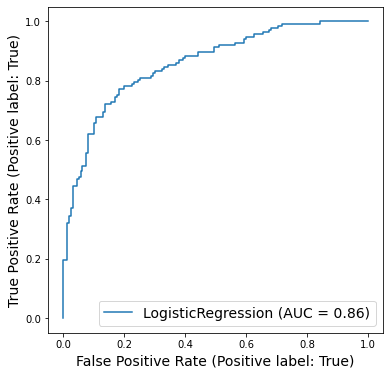

In [14]:
d = plot_roc_curve(logit_reg, hearts_cont, hearts.Disease)

# formatting stuff
d.ax_.set_xlabel(d.ax_.get_xlabel(), fontsize=14)
d.ax_.set_ylabel(d.ax_.get_ylabel(), fontsize=14)
d.figure_.set_figheight(6)
d.figure_.set_figwidth(6)
d.ax_.legend(fontsize=14)

## Appendix 1: Classification with Fewer Predictors

For comparison, we repeat the prediction using only a few predictors. This helps to confirm what is going on! 

In [15]:
hearts_cont1 = hearts.loc[:,['Age']] #, 'RestBP', 'Chol', 'MaxRate', 'ECG_ST_d', 'Vessels']]
hearts_cont1
logit_reg1 = LogisticRegression(penalty='none')
logit_reg1.fit(hearts_cont1, hearts.Disease)
logit_reg1.classes_
names = hearts_cont1.columns.values
beta = logit_reg1.coef_[0]  
for i in range(0,len(names)):
    print('Predictor %s has beta = %4.3f' % (names[i], beta[i]))
print('Intercept = %4.3f' % logit_reg1.intercept_[0])

Predictor Age has beta = 0.053
Intercept = -3.051


In [16]:
true_proba1 = logit_reg1.predict_proba(hearts_cont1)[:,1] 
                # the prediction gives a probability for each class, in order of classes_
results1 = pd.DataFrame(data = {'Disease':hearts.Disease, 'Predicted-disease':true_proba1})
#results1

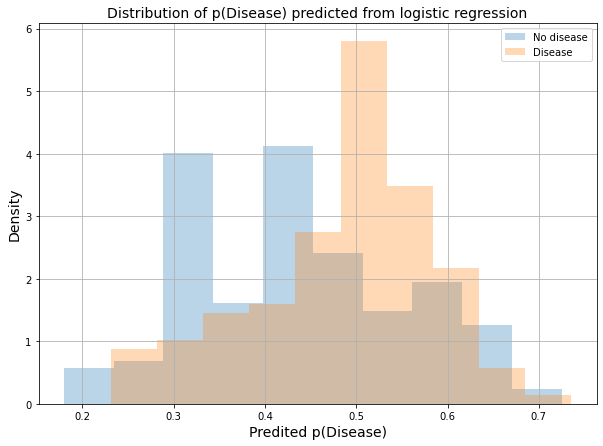

In [17]:
g = results1.groupby('Disease')
fig, ax1 = plt.subplots(1, 1, figsize=(10,7))
(ax_false, ax_true) = g.hist(column=['Predicted-disease'], ax = ax1, 
                             alpha=0.3, legend=False, density=True)
ax1.legend(['No disease', 'Disease'])
ax1.set_xlabel('Predited p(Disease)', fontsize=14)
ax1.set_ylabel('Density', fontsize=14)
_ = ax1.set_title('Distribution of p(Disease) predicted from logistic regression', fontsize=14)

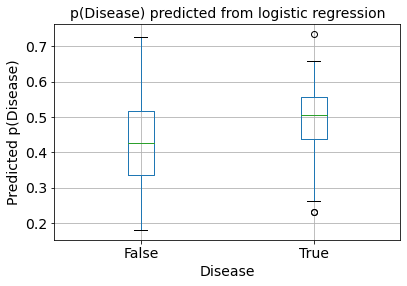

In [18]:
ax = results1.boxplot(column='Predicted-disease', by='Disease', fontsize=14)
_ = plt.suptitle('')
ax.set_xlabel('Disease', fontsize=14)
ax.set_ylabel('Predicted p(Disease)', fontsize=14)
_ = ax.set_title('p(Disease) predicted from logistic regression', fontsize=14)

## Appendix 2: Illustrations


We draw the logit function. This is not practically useful.

Text(0, 0.5, 'Log of Odds Ratio')

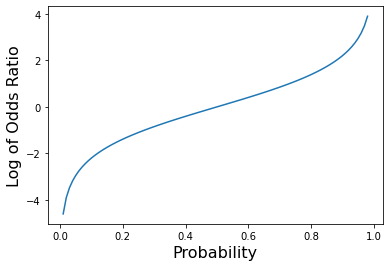

In [19]:
def logit(p):
    return np.log(p / (1-p))

fig, ax = plt.subplots(1,1)
xs = np.arange(0.01, 0.99, 0.01)
ys = logit(xs)
ax.plot(xs, ys)
ax.set_xlabel("Probability", fontsize=16)
ax.set_ylabel("Log of Odds Ratio", fontsize=16)

The inverse of the log odds function is often called $\sigma$ ('sigma') as it follows the shape of an S. The shape is similar to that of the cumulative distribution function (CDF) of a normal distribution: this observation leads to the 'probit' rather than 'logit' regression. 

Text(0.5, 0, 'Log of Odds Ratio')

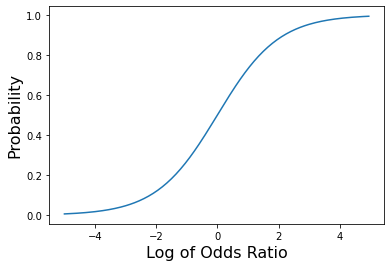

In [20]:
def sigma(logit):
    odds = np.exp(logit)
    return odds / (odds+1)

fig, ax = plt.subplots(1,1)
xs = np.arange(-5.0, 5.0, 0.05)
ys = sigma(xs)
ax.plot(xs, ys)
ax.set_ylabel("Probability", fontsize=16)
ax.set_xlabel("Log of Odds Ratio", fontsize=16)

We also show a scatter plot of the outcome against one of the predictors to show the need for logistic regression, as linear regression cannot directly handle the binary case.

Text(0, 0.5, 'Disease Status')

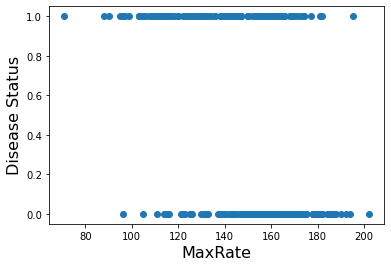

In [21]:
fig, ax = plt.subplots(1, 1)
ax.scatter(hearts.MaxRate, hearts.Disease.values)
ax.set_xlabel('MaxRate', fontsize=16)
ax.set_ylabel('Disease Status', fontsize=16)